In [1]:
from astropy.io import fits
from astropy.table import Table
#import astropy.coordinates as acoords
#from astropy import units as u

import gaia_tools.xmatch
from gaia_tools import query

from astroNN.gaia import extinction_correction , mag_to_fakemag, fakemag_to_logsol
from astroNN.apogee import allstar, visit_spectra
from astroNN.apogee.chips import apogee_continuum

import h5py

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np


Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


### Match between Gaia EDR3 and APOGEE DR16

In [2]:
local_path = '/home/anell/Desktop/Bovy/'

#PONER DE DONDE SAQUÉ APOGEEDR16
apogeedr16 = fits.getdata(f'{local_path}SDSS_LOCAL_SAS_MIRROR/dr16/apogee/spectro/aspcap/r12/l33/allStar-r12-l33.fits')

#Verificar si gaia_tools es la última versión
#gaia_matches, matches_indx = gaia_tools.xmatch.cds(apogeedr16, colRA='ra', colDec='dec', xcat='vizier:I/350/gaiaedr3', gaia_all_columns=True)


# En esta primera parte se recogen los datos de Gaia que tienen un potencial frente a los datos de APOGEE 

In [49]:
len(gaia_matches), len(apogeedr16)

In [11]:
gaia_matches

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,RA,DEC
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg,,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 538028216707715712,538028216707715712,556261869,2016.0,0.0002052024238820092,0.0174189,74.28543607186924,0.015699178,0.2854416643384685,0.01947503,14.656802,0.5245033,0.048581990982767526,0.02403152,0.5222484917399337,0.022098111,0.023568485,-0.030460875,-0.19765584,-0.027202204,0.048995327,-0.045646433,0.08021774,-0.12843376,0.22980696,-0.07332675,354,354,348,6,0.4538917,1600.5779,0.18764412,42.238556,31,True,1.2597554,--,--,--,--,--,--,--,40,25,0.0339504,46,12,0,0.017799057,83.13259,1,0,1.0164024,--,--,--,--,--,--,--,--,False,395,393926.9303916319,284.58813,1384.2001,11.698828,42,67068.36002689962,247.08754,271.4356,13.272248,42,502264.7149217262,746.22296,673.0759,10.4955635,0,0,0,0,0,1.4452758,2.7766848,1.5734205,1.2032642,-51.92466,0.3656457,15,4000.0,3.0,0.0,119.40183992596612,11.767284133180837,54.72695888996762,62.02946734827222,0.00010300000002416709,74.285408
1636042515805110273,Gaia EDR3 2413929812587459072,2413929812587459072,350993523,2016.0,0.0009695048054116059,0.22380865,-19.41392221986823,0.2157498,0.08209285746291617,0.3150806,0.26054558,

In [16]:
gaia_matches.remove_columns(['designation', 'astrometric_primary_flag'])

pandat = gaia_matches.filled(fill_value=-9999.).to_pandas()  # fills the empty spaces with -9999. 
t = Table.from_pandas(pandat)
t.write('xmatch_apogeedr16_gaiaedr3_allcolumns.fits')

### Open and save the file 

In [3]:
# open the file back
xmatched_allcolumns = fits.getdata('xmatch_apogeedr16_gaiaedr3_allcolumns.fits')

# set -9999. to 0 to properly match them
pmra_nan_idx = (xmatched_allcolumns['pmra']==-9999.)
pmdec_nan_idx = (xmatched_allcolumns['pmdec']==-9999.)
xmatched_allcolumns['pmra'][pmra_nan_idx] = 0
xmatched_allcolumns['pmdec'][pmdec_nan_idx] = 0

In [4]:
# But then we only interested in a handful of columns
# and we want the .fits to nicely match allstar from row to row
# USE 'ra' and 'dec' in all_columns !!!!!!! NOT 'RA' and 'DEC'

# En esta segunda etapa se hace el link entre Gaia potencial y APOGEE
# Para hacer el match, usamos la función gaia_tools.xmatch ya que considera el movimiento propio de las estrellas,
# lo cual no es trivial de hacer a mano.
idx_1, idx_2, sep = gaia_tools.xmatch.xmatch(apogeedr16, xmatched_allcolumns, colRA2='ra',colDec2='dec', epoch2=2016.0)
ra = apogeedr16['ra']
dec = apogeedr16['dec']

# set them back
xmatched_allcolumns['pmra'][pmra_nan_idx] = -9999.
xmatched_allcolumns['pmdec'][pmdec_nan_idx] = -9999.

ra2016 = np.ones(ra.shape[0]) * -9999.
dec2016 = np.ones(ra.shape[0]) * -9999.
parallax = np.ones(ra.shape[0]) * -9999.
parallax_error = np.ones(ra.shape[0]) * -9999.
visibility_periods_used  = np.ones(ra.shape[0]) * -9999.
ruwe  = np.ones(ra.shape[0]) * -9999.
pmra = np.ones(ra.shape[0]) * -9999.
pmra_error = np.ones(ra.shape[0]) * -9999.
pmdec = np.ones(ra.shape[0]) * -9999.
pmdec_error = np.ones(ra.shape[0]) * -9999.
phot_g_mean_mag = np.ones(ra.shape[0]) * -9999.
bp_rp = np.ones(ra.shape[0]) * -9999.

ra2016[idx_1] = xmatched_allcolumns['ra'][idx_2]
dec2016[idx_1] = xmatched_allcolumns['dec'][idx_2]
parallax[idx_1] = xmatched_allcolumns['parallax'][idx_2]
parallax_error[idx_1] = xmatched_allcolumns['parallax_error'][idx_2]
visibility_periods_used[idx_1] = xmatched_allcolumns['visibility_periods_used'][idx_2]
ruwe[idx_1] = xmatched_allcolumns['ruwe'][idx_2]
pmra[idx_1] = xmatched_allcolumns['pmra'][idx_2]
pmra_error[idx_1] = xmatched_allcolumns['pmra_error'][idx_2]
pmdec[idx_1] = xmatched_allcolumns['pmdec'][idx_2]
pmdec_error[idx_1] = xmatched_allcolumns['pmdec_error'][idx_2]
phot_g_mean_mag[idx_1] = xmatched_allcolumns['phot_g_mean_mag'][idx_2]
bp_rp[idx_1] = xmatched_allcolumns['bp_rp'][idx_2]

col = []
col.append(fits.Column(name='APOGEE_ID', array=apogeedr16['APOGEE_ID'], format="18A"))
col.append(fits.Column(name='LOCATION_ID', array=apogeedr16['LOCATION_ID'], format="J"))
col.append(fits.Column(name='RA', array=apogeedr16['RA'], format='D'))
col.append(fits.Column(name='DEC', array=apogeedr16['DEC'], format='D'))
col.append(fits.Column(name='RA_J2016', array=ra2016, format='D'))
col.append(fits.Column(name='DEC_J2016', array=dec2016, format='D'))
col.append(fits.Column(name='parallax', array=parallax, format='D'))
col.append(fits.Column(name='parallax_error', array=parallax_error, format='D'))
col.append(fits.Column(name='visibility_periods_used', array=visibility_periods_used, format='I'))
col.append(fits.Column(name='ruwe', array=ruwe, format='J'))
col.append(fits.Column(name='pmra', array=pmra, format='D'))
col.append(fits.Column(name='pmra_error', array=pmra_error, format='D'))
col.append(fits.Column(name='pmdec', array=pmdec, format='D'))
col.append(fits.Column(name='pmdec_error', array=pmdec_error, format='D'))
col.append(fits.Column(name='phot_g_mean_mag', array=phot_g_mean_mag, format='D'))
col.append(fits.Column(name='bp_rp', array=bp_rp, format='D'))

#t = fits.BinTableHDU.from_columns(col)
#t.writeto('xmatch_apogeedr16_gaiaedr3.fits')

/home/anell/anaconda3/envs/astroML-python37/lib/python3.7/site-packages/gaia_tools-0.2-py3.7.egg/gaia_tools/xmatch/__init__.py:428: UserWarning: You appear to be using a Gaia catalog, but are not setting the epoch to 2015. (DR1) or 2015.5 (DR2), which may lead to incorrect matches
  warnings.warn("You appear to be using a Gaia catalog, but are not setting the epoch to 2015. (DR1) or 2015.5 (DR2), which may lead to incorrect matches")


In [50]:
len(idx_1) , len(idx_2)

(468991, 468991)

In [51]:
idx_1[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [52]:
idx_2[:10]

# Verficiar ¿por qué se repiten índices en Gaia?

array([0, 1, 2, 2, 4, 5, 6, 7, 8, 9])

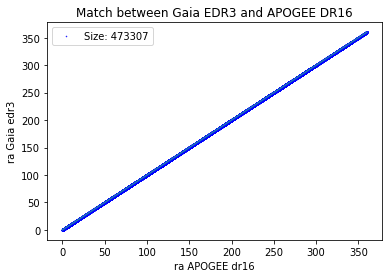

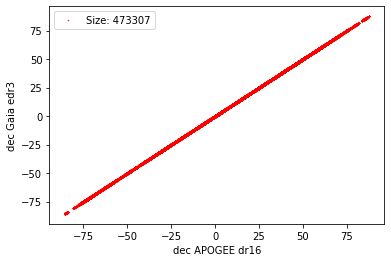

In [53]:
### To be sure of the match
idx = []
for i in range(len(ra)):
    if ra2016[i] != -9999.:
        idx.append(i)
plt.title("Match between Gaia EDR3 and APOGEE DR16")
plt.plot(ra[idx],ra2016[idx],'bo',markersize=0.5, label = f'Size: {len(ra)}')
plt.xlabel("ra APOGEE dr16")
plt.ylabel("ra Gaia edr3")
plt.plot(ra[idx],ra[idx])
plt.legend()
plt.show()

plt.plot(dec[idx],dec2016[idx],'ro',markersize=0.5, label = f'Size: {len(ra)}')
plt.xlabel("dec APOGEE dr16")
plt.ylabel("dec Gaia edr3")
plt.legend()
plt.show()

### Compilation of training and testing sets

In [5]:
ra_apogeedr16 = apogeedr16["ra"]  
dec_apogeedr16 = apogeedr16["dec"]
id_apogeedr16 = apogeedr16["APOGEE_ID"]
location_apogeedr16 = apogeedr16["LOCATION_ID"]
snr_apogeedr16 = apogeedr16["SNR"]
teff_apogeedr16 = apogeedr16["TEFF"]
logg_apogeedr16 = apogeedr16['LOGG']
Vradial_apogeedr16 = apogeedr16['VHELIO_AVG']
vscatter_apogeedr16 = apogeedr16["vscatter"]  
starflag_apogeedr16 = apogeedr16['STARFLAG'] 
feh_apogeedr16 = apogeedr16['FE_H']

extinction_apogeedr16 = apogeedr16['AK_TARG']
extinction_apogeedr16[extinction_apogeedr16 < 0.] = -9999  # assume corrupted extinction if negative extinction
Kmag_apogeedr16 = extinction_correction(apogeedr16["K"], extinction_apogeedr16) 


fakemag, fakemag_error = mag_to_fakemag(Kmag_apogeedr16, parallax, parallax_error)
logsol = fakemag_to_logsol(fakemag)


In [6]:
len(ra_apogeedr16) , len(parallax) , len(parallax_error)

(473307, 473307, 473307)

In [7]:
# cutting criteria for training set
# entender (logsol > 0) | (parallax < 0) ¿que pasa con estas estrellas?
good_idx = ((parallax != -9999.) & (parallax_error < 0.1) & (snr_apogeedr16 >= 200) & 
            (Kmag_apogeedr16 != -9999) & (vscatter_apogeedr16 < 1.) & (starflag_apogeedr16 == 0) &
             ((logsol > 0) | (parallax < 0)))

# cutting criteria for testing set
good_test_idx = ((parallax != -9999.) & (parallax_error < 0.1) & (snr_apogeedr16 < 200) & 
            (Kmag_apogeedr16 != -9999) & (vscatter_apogeedr16 < 1.) & (starflag_apogeedr16 == 0) &
             ((logsol > 0) | (parallax < 0)))

print("Training Set Spectra: ", np.sum(good_idx))
print("Low SNR Combined Spectra Testing Set Spectra: ", np.sum(good_test_idx))

Training Set Spectra:  85070
Low SNR Combined Spectra Testing Set Spectra:  113560


Spectra download

In [8]:
def apstar_normalization(spectra, spectra_err, _spec_mask):
    target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=16, bitmask=_spec_mask, target_bit=target_bit)

def spectra_download(apogee_id , location_id, save_str):
    local_path = '/home/anell/Desktop/Bovy/AnellExercises/Fits_files'
    spec = np.zeros((len(apogee_id), 7514), dtype=np.float32)  
    path_spectra = []
    for counter in range(0, len(apogee_id)):
        if location_id[counter] == 1:
            continue
        ap_path = visit_spectra(dr=16, apogee = apogee_id[counter],
                                location= location_id[counter], verbose=0)
        if ap_path is False:
            pass
        else:
            path_spectra.append(ap_path) #anell
            apstar_file = fits.open(ap_path)
            nvisits = apstar_file[0].header['NVISITS']
            if nvisits == 1:
                _spec = apstar_file[1].data
                _spec_err = apstar_file[2].data
                _spec_mask = apstar_file[3].data
            else:
                _spec = apstar_file[1].data[1]
                _spec_err = apstar_file[2].data[1]
                _spec_mask = apstar_file[3].data[1]

            if not np.all(_spec==0.): #normaliza los espectros que tenga alguno de sus elementos distintos de 0
                _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
                spec[counter] = _spec
        print(counter)

    if save_str != None:
        # save spec to fits file
        hdu = fits.PrimaryHDU(spec)
        hdu.writeto(f'{save_str}')    
        
    return spec , path_spectra

In [9]:
apogee_id_train = id_apogeedr16[good_idx]
location_id_train = location_apogeedr16[good_idx]

#have to remove index 14517

train_spec_1 , _ = spectra_download(apogee_id_train[14518:] , location_id_train[14518:], 'train_spec_1')

/home/anell/Desktop/Bovy/SDSS_LOCAL_SAS_MIRROR/dr16/apogee/spectro/aspcap/r12/l33/allStar-r12-l33.fits was found!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038


3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680


Downloaded DR16 individual visit file successfully to /home/anell/Desktop/Bovy/SDSS_LOCAL_SAS_MIRROR/dr16/apogee/spectro/redux/r12/stars/apo25m/191+00/apStar-r12-2M06105167+1828058.fits
5024


KeyboardInterrupt: 

In [54]:
apogee_id_test = id_apogeedr16[good_test_idx]
location_id_test = location_apogeedr16[good_test_idx]



test_spec_1 , _ = spectra_download(apogee_id_test[:] , location_id_test[:], None)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
144
145
147
148
149
150
151
152
153
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
173
174
175
176
177
178
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
223
224
225
226
227
228
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287


TypeError: buffer is too small for requested array

In [14]:
print(train_spec_1.shape,test_spec_1.shape)

(14516, 7514) (1506, 7514)


In [15]:
#train_spec_1 = fits.open('contspec_dr14_train.fits')[0].data

# spectra cutting criteria for training set
good_idx_spectra = np.all(train_spec_1 != 0., axis=1)

# spectra cutting criteria for testing set
good_test_idx_spectra =  np.all(test_spec_1 != 0., axis=1)

print("Training Set Spectra: ", np.sum(good_idx_spectra))
print("Low SNR Combined Spectra Testing Set Spectra: ", np.sum(good_test_idx_spectra))

Training Set Spectra:  13976
Low SNR Combined Spectra Testing Set Spectra:  1320


In [25]:
h5f = h5py.File('train_set_gaiaedr3_apogeedr16_1.h5', 'w')
h5f.create_dataset('spectra', data=train_spec_1[good_idx_spectra])
h5f.create_dataset('RA', data=ra_apogeedr16[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('DEC', data=dec_apogeedr16[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('SNR', data=snr_apogeedr16[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('ASPCAP_TEFF', data=teff_apogeedr16[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('ASPCAP_LOGG', data=logg_apogeedr16[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('fakemag', data=fakemag[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('fakemag_err', data=fakemag_error[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('corrected_K', data=Kmag_apogeedr16[good_idx][:14516][good_idx_spectra])  # extinction corrected
h5f.create_dataset('parallax', data=parallax[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('parallax_err', data=parallax_error[good_idx][:14516][good_idx_spectra])
h5f.create_dataset('fe_eh', data=feh_apogeedr16[good_idx][:14516][good_idx_spectra])
#h5f.create_dataset('bp_rp', data=gaia_data_file['bp_rp'][good_idx][:14516][good_idx_spectra])
#h5f.create_dataset('phot_g_mean_mag', data=gaia_data_file['phot_g_mean_mag'][good_idx][:14516][good_idx_spectra])
h5f.close()


h5f = h5py.File('test_set_gaiaedr3_apogeedr16_1.h5', 'w')
h5f.create_dataset('spectra', data=test_spec_1[good_test_idx_spectra])
h5f.create_dataset('RA', data=ra_apogeedr16[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('DEC', data=dec_apogeedr16[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('SNR', data=snr_apogeedr16[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('ASPCAP_TEFF', data=teff_apogeedr16[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('ASPCAP_LOGG', data=logg_apogeedr16[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('fakemag', data=fakemag[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('fakemag_err', data=fakemag_error[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('corrected_K', data=Kmag_apogeedr16[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('parallax', data=parallax[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('parallax_err', data=parallax_error[good_test_idx][:1506][good_test_idx_spectra])
h5f.create_dataset('fe_eh', data=feh_apogeedr16[good_test_idx][:1506][good_test_idx_spectra])
#h5f.create_dataset('bp_rp', data=gaia_data_file['bp_rp'][good_idx][:14516][good_idx_spectra])
#h5f.create_dataset('phot_g_mean_mag', data=gaia_data_file['phot_g_mean_mag'][good_idx][:14516][good_idx_spectra])
h5f.close()


## Exploration

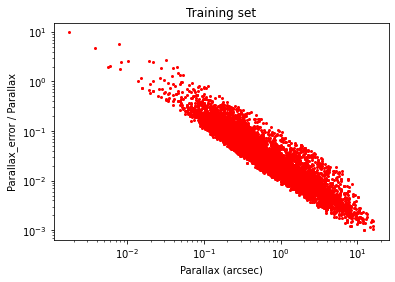

In [46]:
parallax_train = parallax[good_idx][:14516][good_idx_spectra]
parallax_error_train = parallax_error[good_idx][:14516][good_idx_spectra]

idx = []
for i in range(len(parallax_train)):
    if parallax_train[i] != -9999. or parallax_error_train[i] != -9999.:
        idx.append(i)
d = parallax_error_train[idx] / parallax_train[idx] 
        
plt.plot(parallax_train[idx], d,'ro', markersize=2)
plt.xlabel('Parallax (arcsec)')
plt.ylabel('Parallax_error / Parallax')
plt.title('Training set')
plt.yscale('log')
plt.xscale('log')
plt.show()

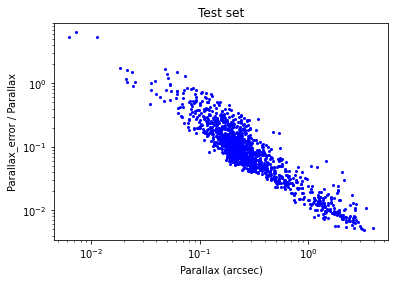

In [47]:
parallax_test = parallax[good_test_idx][:1506][good_test_idx_spectra]
parallax_error_test = parallax_error[good_test_idx][:1506][good_test_idx_spectra]

idx = []
for i in range(len(parallax_test)):
    if parallax_test[i] != -9999. or parallax_error_test[i] != -9999.:
        idx.append(i)
d = parallax_error_test[idx] / parallax_test[idx] 
        
plt.plot(parallax_test[idx], d,'bo', markersize=2)
plt.xlabel('Parallax (arcsec)')
plt.ylabel('Parallax_error / Parallax')
plt.title('Test set')
plt.yscale('log')
plt.xscale('log')
plt.show()